In [8]:
import numpy as np
import random
import math
import matplotlib
import matplotlib.pyplot as plt
import heapq

In [30]:
# Initial conditions
n = 100 # number of trash
m = 5 # size of grid
k = 6 # number of agents
mu = [3, 2] # center of trash pile
sig = [[0.1, 0], [0, 0.1]] # spread of pile
var = 0.1 # error in measurements

T = n # number of time steps
delta = 1 # amount reward decreases per visit
xi = 2 # constant xi > 1
gamma = 3 # max message length
thresh = 0 # Maximum amount trash

messageSent = {}# dict {agent: list of messages to send - tuple [agent, time, arm, reward]}
messageRec = {}# dict {agent: list of messages received - tuple [agent, time, arm, reward]}

In [31]:
# Testing parameters

test = 100 # number of tests run
# results matrix
# row = test number = fixed trash distribution across columns
# column = degree of each agent in communication network
timestep = np.zeros((test, k))
regret = np.zeros((test, k)) # size = [test][cumulative regret]

In [32]:
for count in range(test):
    print("Test number: {}".format(count))
    
    # Reset field
    field = np.zeros((m,m))# array of trash pieces dispersed on field
    
        
    # Initialize field
    trash = np.random.multivariate_normal(mu, sig, n)
    for i in range(n):
        x = int(trash[i][0])
        y = int(trash[i][1])
        field[x][y] += 1
    print(field)
    
    for degree in range(k):
        print("Degree: {}".format(degree))
        # Reset matrices used for calculation 
        field_temp = field.copy()
        visits = np.zeros((k,m,m))# array to track number of visits to each gridpoint
        reward = np.zeros((k,m,m))# array of sum of rewards from each gridpoint
        expected_mean = np.zeros((k,m,m)) # array of expected mean of each gridpoint
        
        # Reset Messages
        for i in range(k):
            messageSent[i] = []
            messageRec[i] = []
        
        # Initialize communication network
        graph = np.identity(k)
        if degree % 2 == 0:
            num = int(degree/2)
            for j in range(num):
                # make vertex for every (i +1) steps away
                for i in range(k):
                    neighbor = int(i + j + 1)
                    if neighbor > (k-1):
                        neighbor = neighbor - k
                    graph[i][neighbor] = 1
                    graph[neighbor][i] = 1
        else:
            num = int((degree-1)/2 + 1)
            for j in range(num):
                # make vertex for every n/2 - i steps away
                for i in range(k):
                    neighbor = int(i + k/2 - j)
                    if neighbor > (k-1):
                        neighbor = neighbor - k
                    graph[i][neighbor] = 1
                    graph[neighbor][i] = 1
                    
        # Initialize agents
        t = 0
        for i in range(k):
            for x in range(m):
                for y in range(m):
                    measure = round(np.random.normal(field_temp[x][y], var),1)
                    reward[i][x][y] += measure
                    visits[i][x][y] += 1

            # Calculate expected mean
            expected_mean[i] = np.divide(reward[i], visits[i])
        
        t += 1
        while np.max(field_temp) > thresh:
            print("t: {}".format(t))
            index = []
            for i in range(k):
                # Select arm with highest expected Q value
                # Select arm with highest expected Q value
                Q = expected_mean[i] + var*np.divide(math.sqrt(2*(xi + 1)*math.log(t)),np.sqrt(visits[i]))
                Q_new = Q.reshape(m**2).tolist()
                b = heapq.nlargest(k, range(len(Q_new)), key=Q_new.__getitem__)
                ind = np.unravel_index(b[i], Q.shape)
                measure = np.round(np.random.normal(field_temp[ind], var),1)
                index.append(ind)

                #print(ind)
                #print(Q)
                #print(measure)

                # Calculate regret
                field_new = field_temp.reshape(m**2).tolist()
                c = heapq.nlargest(k, range(len(field_new)), key = field_new.__getitem__)
                optimal_ind = np.unravel_index(c[i], field_temp.shape)
                # optimal_ind = np.unravel_index(np.argmax(field), field.shape)
                max_reward = field_temp[optimal_ind]
                actual_reward = field_temp[ind]
                #if actual_reward < 0:
                 #   actual_reward = 0            
                regret[count][degree] += (max_reward - actual_reward)                


                # Make message to send to neighboring agents
                message = (t, i, ind, measure)
                send = messageSent[i]
                if len(send) == gamma:
                    send.pop(0)
                send.append(message)
                messageSent[i] = send

            # Pick up trash from selected grid points
            for i in range(len(index)):
                ind = index[i]
                if (field[ind] > 0):
                    field_temp[ind] -= 1


            # receive messages from neighbors and adjust expected mean
            for i in range(k):
                #print(i)
                new_visits= np.zeros((m,m))
                # compare new messages with history of messages and skip any repeats
                for j in range(k):
                    if graph[i][j] == 1:
                        received = messageRec[i]
                        sent = messageSent[j]
                        for l in range(len(sent)):
                            msg = sent[l]
                            if received.count(msg) == 0:
                                received.append(msg)
                                ind = msg[2]
                                visits[i][ind] += 1
                                new_visits[ind] += 1
                                reward[i][ind] += msg[3]
                        messageRec[i] = received

                # calculate expected mean
                reward[i] -= np.multiply(new_visits, visits[i])
                expected_mean[i] = np.divide(reward[i], visits[i])
                #print(reward[i])
                #print(visits[i])
                #print(expected_mean[i])           
            # Next time step
            # print(field_temp)
            t += 1
            
        timestep[count][degree] = t
    

Test number: 0
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 32. 17.  0.  0.]
 [ 0. 33. 18.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
t: 49
t: 50
t: 51
t: 52
t: 53
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
t: 49
t: 50
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
Degree: 3
t: 1
t: 2
t: 3
t

t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t:

t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
Test number: 11
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 22. 28.  0.  0.]
 [ 0. 13. 36.  0.  0.]
 [ 0.  0.  1.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45

t: 26
t: 27
t: 28
Test number: 16
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 23. 28.  0.  0.]
 [ 0. 21. 28.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
t: 49
t: 50
t: 51
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 

t: 45
t: 46
t: 47
t: 48
t: 49
t: 50
t: 51
t: 52
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
t: 49
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26


t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
Test number: 27
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 21. 24.  0.  0.]
 [ 0. 29. 26.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
t: 49
t: 50
t: 51
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17


t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
Test number: 32
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 28. 25.  0.  0.]
 [ 0. 27. 18.  0.  0.]
 [ 0.  1.  1.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
t: 49
t: 50
t: 51
t: 52
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t

t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
Test number: 38
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 19. 23.  0.  0.]
 [ 0. 25. 33.  0.  0.]
 [ 

t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
Test number: 43
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 24. 26.  0.  0.]
 [ 0. 21. 29.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
t: 49
t

t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
Test number: 48
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 26. 22.  0.  0.]
 [ 0. 21. 31.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
t: 49
t: 50
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t

Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t

t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
Test number: 59
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1. 17. 33.  0.  0.]
 [ 0. 28. 21.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
t: 49
t: 50
t: 51
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 

t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
Test number: 64
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 40. 15.  0.  0.]
 [ 0. 20. 25.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
t: 49
t: 50
t: 51
t: 52
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
t: 49
Degree: 2
t: 

t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
Test number: 69
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 26. 26.  0.  0.]
 [ 0. 26. 22.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
t: 49
t: 50
t: 51
t: 52
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16


t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
t: 49
t: 50
t: 51
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28


t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28


t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
Test number: 85
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 17. 25.  0.  0.]
 [ 0. 28. 30.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10


t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
Degree: 5
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
Test number: 90
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0. 21. 26.  0.  0.]
 [ 0. 26. 26.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Degree: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 2

t: 50
Degree: 1
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
Degree: 2
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
Degree: 3
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
Degree: 4
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
Degree: 5
t: 1
t: 2
t: 3

In [33]:
print(timestep)

[[54. 51. 38. 48. 37. 34.]
 [52. 50. 43. 45. 40. 37.]
 [50. 48. 37. 43. 36. 30.]
 [50. 48. 39. 42. 39. 30.]
 [51. 48. 37. 43. 36. 30.]
 [50. 48. 41. 44. 41. 37.]
 [51. 48. 39. 43. 38. 33.]
 [53. 48. 37. 41. 36. 28.]
 [53. 50. 47. 47. 44. 41.]
 [51. 48. 38. 44. 36. 31.]
 [51. 48. 38. 42. 36. 30.]
 [54. 49. 42. 46. 38. 37.]
 [50. 48. 39. 44. 37. 33.]
 [52. 51. 41. 44. 33. 29.]
 [50. 49. 37. 43. 36. 30.]
 [53. 49. 40. 43. 34. 29.]
 [52. 48. 37. 44. 36. 30.]
 [52. 49. 37. 43. 36. 29.]
 [51. 48. 38. 43. 37. 32.]
 [51. 48. 38. 43. 36. 29.]
 [51. 49. 38. 43. 34. 29.]
 [53. 50. 39. 46. 36. 33.]
 [52. 50. 37. 45. 35. 30.]
 [53. 49. 39. 42. 34. 28.]
 [52. 48. 39. 42. 35. 29.]
 [48. 47. 40. 43. 40. 34.]
 [51. 49. 37. 44. 36. 30.]
 [52. 48. 38. 43. 36. 30.]
 [50. 48. 42. 43. 41. 37.]
 [52. 50. 40. 43. 34. 29.]
 [52. 49. 39. 46. 38. 35.]
 [52. 48. 37. 44. 35. 30.]
 [53. 49. 39. 43. 34. 29.]
 [52. 49. 38. 45. 37. 33.]
 [51. 48. 38. 43. 35. 30.]
 [51. 48. 40. 43. 35. 30.]
 [50. 48. 39. 44. 38. 34.]
 

In [34]:
avg = np.average(timestep, axis = 0)
std = np.std(timestep, axis = 0, ddof = 1)
sem = std/np.sqrt(test)
print(avg)
print(std)

[51.3  48.42 38.98 43.65 36.49 31.46]
[2.0523453  2.37061131 1.76943751 1.64761842 2.05723655 2.92816349]


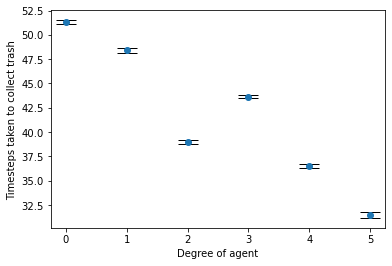

In [35]:
fig, ax = plt.subplots()
xpos = np.arange(len(avg))
ax.errorbar(xpos, avg, yerr = sem, fmt = 'o', ecolor='black', capsize=10)
ax.set_xticks(np.arange(k))
ax.set_xlabel("Degree of agent")
ax.set_ylabel("Timesteps taken to collect trash")
plt.show()

In [36]:
avg_regret = np.average(regret, axis = 0)
std_regret = np.std(regret, axis = 0, ddof = 1)
sem_regret = std_regret/np.sqrt(test)
print(avg_regret)
print(std_regret)

[415.07 402.64 145.4  289.05  60.33   7.47]
[60.30030152 59.14039451 30.22107098 28.42547406 17.41823902  4.09842295]


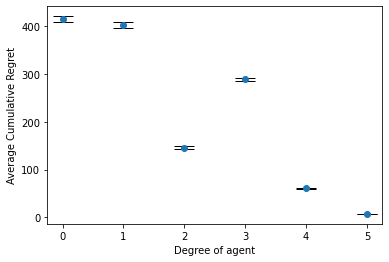

In [37]:
fig, ax1 = plt.subplots()
xpos = np.arange(len(avg))
ax1.errorbar(xpos, avg_regret, yerr = sem_regret, fmt = 'o', ecolor='black', capsize=10)
ax1.set_xlabel("Degree of agent")
ax1.set_ylabel("Average Cumulative Regret")
plt.show()

In [165]:
print(regret)

[[1.382e+03 6.440e+02 3.240e+02 1.590e+02 5.800e+01 0.000e+00]
 [1.730e+02 1.180e+02 5.600e+01 2.600e+01 4.800e+01 0.000e+00]
 [5.140e+02 1.980e+02 2.140e+02 1.470e+02 2.000e+00 0.000e+00]
 [4.720e+02 2.560e+02 1.410e+02 4.800e+01 0.000e+00 0.000e+00]
 [3.200e+02 1.140e+02 9.000e+01 0.000e+00 0.000e+00 0.000e+00]
 [5.920e+02 3.480e+02 9.600e+01 1.130e+02 0.000e+00 0.000e+00]
 [3.570e+02 1.900e+02 3.600e+01 2.100e+01 0.000e+00 0.000e+00]
 [5.450e+02 3.000e+02 2.740e+02 7.000e+01 7.000e+00 0.000e+00]
 [6.350e+02 3.120e+02 2.380e+02 6.600e+01 8.000e+00 0.000e+00]
 [3.120e+02 1.460e+02 2.400e+01 5.400e+01 0.000e+00 0.000e+00]
 [1.950e+02 1.320e+02 1.100e+02 5.400e+01 0.000e+00 0.000e+00]
 [5.950e+02 2.340e+02 9.000e+01 6.600e+01 7.000e+00 0.000e+00]
 [3.000e+02 2.020e+02 3.600e+01 0.000e+00 0.000e+00 0.000e+00]
 [4.300e+02 2.280e+02 2.180e+02 3.000e+01 0.000e+00 0.000e+00]
 [2.940e+02 2.240e+02 1.960e+02 2.400e+01 2.310e+02 0.000e+00]
 [1.635e+03 6.120e+02 2.100e+02 2.050e+02 1.200e+01 0.0